In [2]:
import pandas as pd
import kagglehub

/Users/imsks/Public/git-repos/learning/learning-ai/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
path = kagglehub.dataset_download("rajanand/crime-in-india")
rape_victims = pd.read_csv(f"{path}/20_Victims_of_rape.csv")
murder_victims = pd.read_csv(f"{path}/32_Murder_victim_age_sex.csv")
# cases_women = pd.read_csv(f"{path}/42_Cases_under_crime_against_women.csv")
# arrests_women = pd.read_csv(f"{path}/43_Arrests_under_crime_against_women.csv")
police_violations = pd.read_csv(f"{path}/35_Human_rights_violation_by_police.csv")
trial_periods = pd.read_csv(f"{path}/29_Period_of_trials_by_courts.csv")
violent_crime_trials = pd.read_csv(f"{path}/28_Trial_of_violent_crimes_by_courts.csv")

In [4]:
# rape_victims.info()

# Fix column names
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("- ", "_")
    )

    return df

rape_victims = clean_column_names(rape_victims)
# rape_victims.info()

In [5]:
# Check for Null data
# rape_victims.isnull().sum()

In [6]:
# Standarize Key Columns
rape_victims['victims_of_rape_total'] = pd.to_numeric(rape_victims['victims_of_rape_total'], errors='coerce').fillna(0)

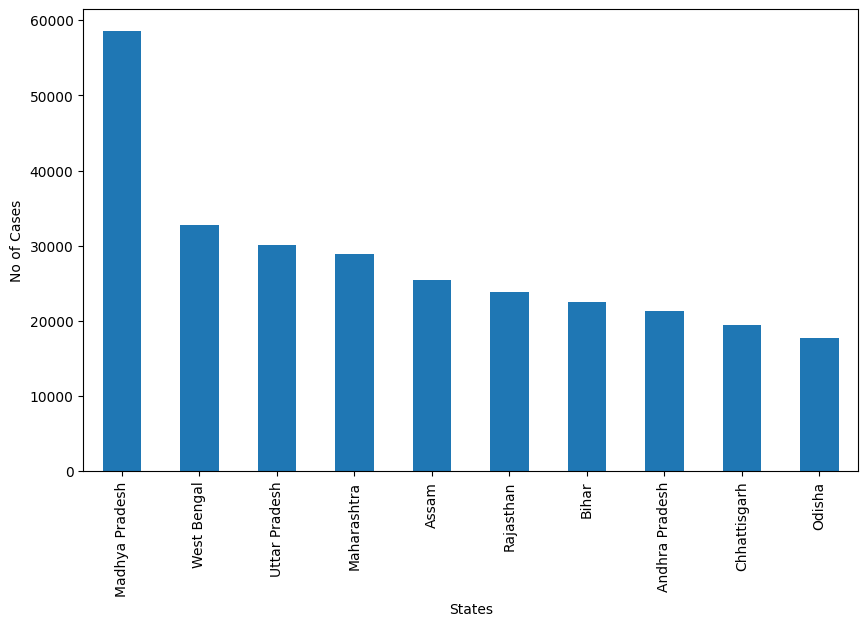

In [7]:
# 1. States with Highest Rape Cases
top_states = rape_victims.groupby('area_name')['rape_cases_reported'].sum().sort_values(ascending=False).head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_states.plot(kind='bar')
plt.xlabel('States')
plt.ylabel('No of Cases')
plt.show()

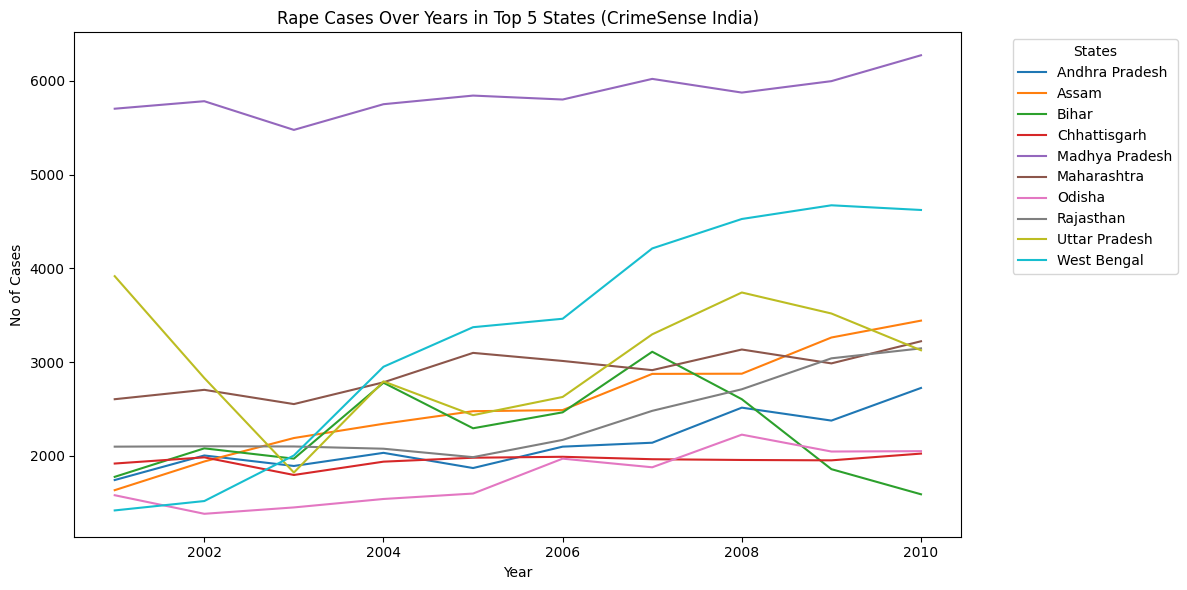

In [8]:
# 2. How Rape Cases have changed over the years in these states
top_states_list = top_states.index.to_list()

rape_top_states = rape_victims[rape_victims['area_name'].isin(top_states_list)]

rape_trends = (
    rape_top_states.groupby(['year', 'area_name'])['victims_of_rape_total'].sum()
    .reset_index()
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=rape_trends, x='year', y='victims_of_rape_total', hue='area_name', markers='o')
plt.title('Rape Cases Over Years in Top 5 States (CrimeSense India)')
plt.xlabel('Year')
plt.ylabel('No of Cases')
plt.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
#  Find the Year with Maximum Reported Rape Cases
max_spike = rape_trends.loc[rape_trends.groupby('area_name')['victims_of_rape_total'].idxmax()].reset_index(drop=True)

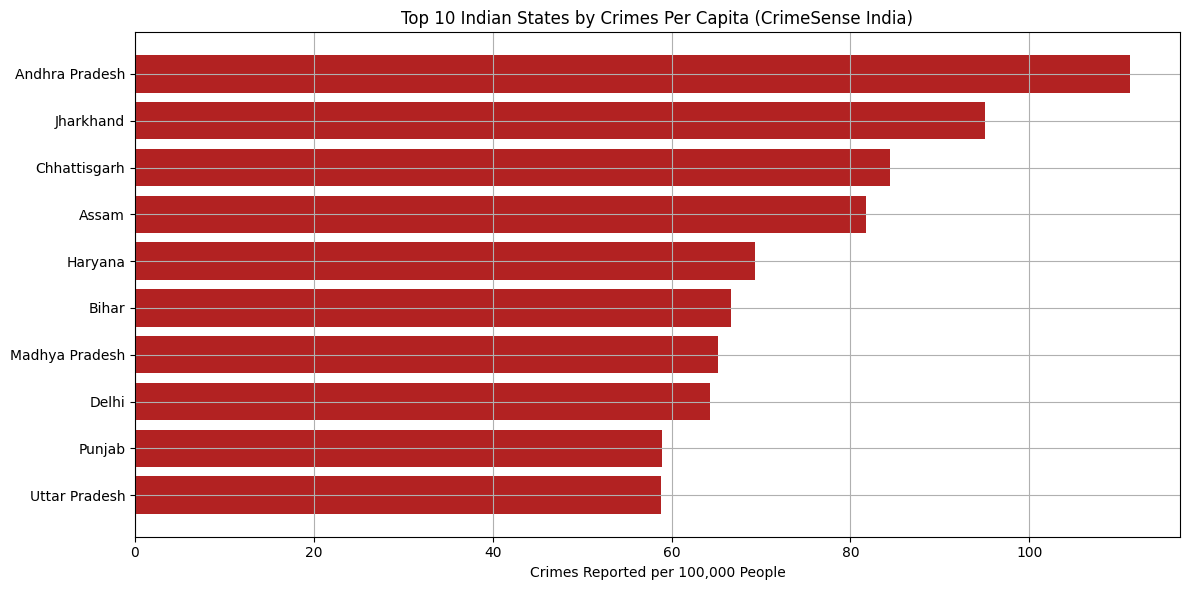

In [10]:
murder_victims = clean_column_names(murder_victims)

top_states = murder_victims.groupby('area_name')["victims_total"].sum().sort_values(ascending=False)

state_population = {
    'Uttar Pradesh': 199812341,
    'Maharashtra': 112374333,
    'Bihar': 104099452,
    'West Bengal': 91276115,
    'Madhya Pradesh': 72626809,
    'Tamil Nadu': 72147030,
    'Rajasthan': 68548437,
    'Karnataka': 61095297,
    'Gujarat': 60439692,
    'Andhra Pradesh': 49386799,
    'Odisha': 41974218,
    'Telangana': 35193978,  # Telangana was created in 2014, adjust if needed
    'Assam': 31205576,
    'Kerala': 33406061,
    'Punjab': 27743338,
    'Haryana': 25351462,
    'Delhi': 16787941,
    'Chhattisgarh': 25545198,
    'Jharkhand': 32988134,
    'Jammu and Kashmir': 12541302

}

top_states_df = top_states.reset_index()

top_states_df.columns = ['area_name', 'victims_total']

top_states_df["population"] = top_states_df["area_name"].map(state_population)

top_states_df["crimes_per_100k"] = (top_states_df["victims_total"] / top_states_df["population"]) * 100000

top_states_df.sort_values(by="crimes_per_100k", ascending=False, inplace=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(top_states_df.head(10)["area_name"], top_states_df.head(10)["crimes_per_100k"], color="firebrick")
plt.xlabel("Crimes Reported per 100,000 People")
plt.title("Top 10 Indian States by Crimes Per Capita (CrimeSense India)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
murder_victims.head()

# Analyzing Uttar Pradesh
up_murder_victims = murder_victims[murder_victims['area_name'] == 'Uttar Pradesh']

pivot_df = up_murder_victims.pivot(index='year', columns='sub_group_name', values='victims_total').reset_index()
up_murder_victims['sub_group_name'] = up_murder_victims['sub_group_name'].replace({
    '1. Male Victims': 'male_victim',
    '2. Female Victims': 'female_victim'
})

pivot_df = up_murder_victims.pivot(index='year', columns='sub_group_name', values='victims_total').reset_index()

# Preparing Female Victims
female_murder = pivot_df[['year', 'female_victim']].copy()
female_murder.rename(columns={'female_victim': 'female_murder_cases'}, inplace=True)
female_murder

# Prepare Rape Victim data
# Filter Uttar Pradesh from rape_victims dataset
up_rape_victims = rape_victims[rape_victims['area_name'] == 'Uttar Pradesh']

# Group by year and sum
rape_by_year = (
    up_rape_victims.groupby('year')['victims_of_rape_total']
    .sum()
    .reset_index()
)

# Combine the two
combined_df = pd.merge(female_murder, rape_by_year, on='year', how='inner')

# Calculate % YOY change
combined_df['female_murder_yoy_change'] = combined_df['female_murder_cases'].pct_change() * 100
combined_df['rape_cases_yoy_change'] = combined_df['victims_of_rape_total'].pct_change() * 100

# Drop Rows if victims_of_rape_total is NaN
# combined_df.dropna(subset=['female_murder_yoy_change'], inplace=True)

# Assigning CMs
def assign_cm(year):
    if 2000 <= year <= 2001:
      return "Ram Prakash Gupta"
    elif 2002 <= year < 2003:
      return "Rajnath Singh"
    elif 2003 <= year <= 2007:
        return "Mulayam Singh Yadav"
    elif 2007 <= year <= 2012:
        return "Mayawati"
    elif 2012 <= year <= 2017:
        return "Akhilesh Yadav"
    else:
        return "Unknown"  # fallback

combined_df['cm_name'] = combined_df['year'].apply(assign_cm)

# Grouping
combined_df.groupby('cm_name')[['female_murder_cases', 'victims_of_rape_total']].sum()

/var/folders/77/4v4826r95v3dmc8hb5s9h9th0000gn/T/ipykernel_7038/418998079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_murder_victims['sub_group_name'] = up_murder_victims['sub_group_name'].replace({


,female_murder_cases,victims_of_rape_total
cm_name,,
Mayawati,2654,10386
Mulayam Singh Yadav,5580,12974
Rajnath Singh,1453,2830
Ram Prakash Gupta,1323,3916


In [13]:
murder_victims.head()

# Analyzing Uttar Pradesh
up_murder_victims = murder_victims[murder_victims['area_name'] == 'Uttar Pradesh']

pivot_df = up_murder_victims.pivot(index='year', columns='sub_group_name', values='victims_total').reset_index()
up_murder_victims['sub_group_name'] = up_murder_victims['sub_group_name'].replace({
    '1. Male Victims': 'male_victim',
    '2. Female Victims': 'female_victim'
})

pivot_df = up_murder_victims.pivot(index='year', columns='sub_group_name', values='victims_total').reset_index()

# Preparing Female Victims
female_murder = pivot_df[['year', 'female_victim']].copy()
female_murder.rename(columns={'female_victim': 'female_murder_cases'}, inplace=True)
female_murder

# Prepare Rape Victim data
# Filter Uttar Pradesh from rape_victims dataset
up_rape_victims = rape_victims[rape_victims['area_name'] == 'Uttar Pradesh']

# Group by year and sum
rape_by_year = (
    up_rape_victims.groupby('year')['victims_of_rape_total']
    .sum()
    .reset_index()
)

# Combine the two
combined_df = pd.merge(female_murder, rape_by_year, on='year', how='inner')

# Calculate % YOY change
combined_df['female_murder_yoy_change'] = combined_df['female_murder_cases'].pct_change() * 100
combined_df['rape_cases_yoy_change'] = combined_df['victims_of_rape_total'].pct_change() * 100

# Drop Rows if victims_of_rape_total is NaN
# combined_df.dropna(subset=['female_murder_yoy_change'], inplace=True)

# Assigning CMs
def assign_cm(year):
    if 2000 <= year <= 2001:
      return "Ram Prakash Gupta"
    elif 2002 <= year < 2003:
      return "Rajnath Singh"
    elif 2003 <= year <= 2007:
        return "Mulayam Singh Yadav"
    elif 2007 <= year <= 2012:
        return "Mayawati"
    elif 2012 <= year <= 2017:
        return "Akhilesh Yadav"
    else:
        return "Unknown"  # fallback

combined_df['cm_name'] = combined_df['year'].apply(assign_cm)

# Grouping
combined_df.groupby('cm_name')[['female_murder_cases', 'victims_of_rape_total']].sum()

/var/folders/77/4v4826r95v3dmc8hb5s9h9th0000gn/T/ipykernel_7038/418998079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_murder_victims['sub_group_name'] = up_murder_victims['sub_group_name'].replace({


,female_murder_cases,victims_of_rape_total
cm_name,,
Mayawati,2654,10386
Mulayam Singh Yadav,5580,12974
Rajnath Singh,1453,2830
Ram Prakash Gupta,1323,3916


<Figure size 1200x600 with 0 Axes>

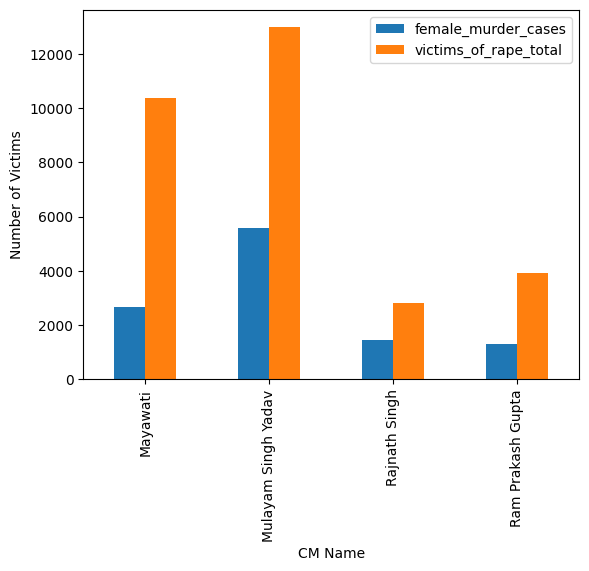

In [14]:
plt.figure(figsize=(12, 6))
# Make Bar Chart for CMs
combined_df.groupby('cm_name')[['female_murder_cases', 'victims_of_rape_total']].sum().plot(kind='bar')
plt.xlabel('CM Name')
plt.ylabel('Number of Victims')
plt.show()

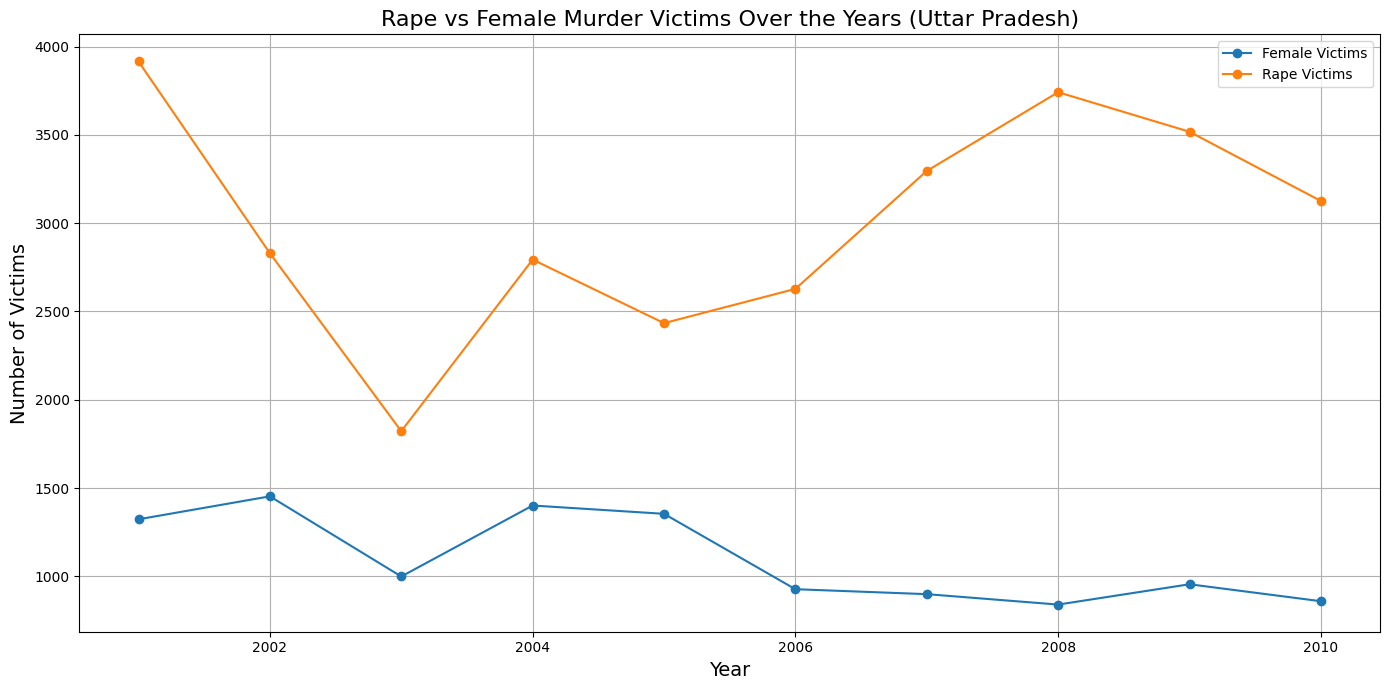

In [15]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(pivot_df['year'], combined_df['female_murder_cases'], marker='o', label='Female Victims')
plt.plot(pivot_df['year'], combined_df['victims_of_rape_total'], marker='o', label='Rape Victims')

plt.title('Rape vs Female Murder Victims Over the Years (Uttar Pradesh)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Victims', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()